In [23]:
import tensorflow as tf
print (tf.__version__)

2.3.0


In [24]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
project_path = '/content/drive/My Drive/external/'

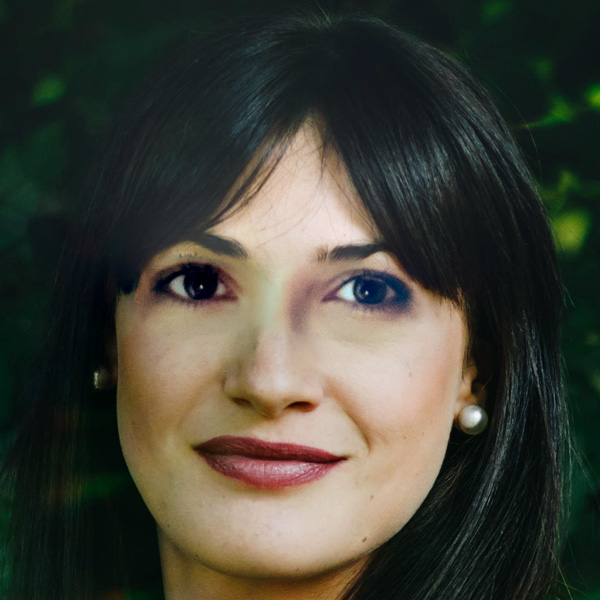

In [27]:
#Load an image using Keras image class
image_file = project_path+'dataset/train/training_fake/100.jpg'
image = tf.keras.preprocessing.image.load_img(image_file)

#Inspect image
image

In [28]:
#Define some parameters
img_size = 256
batch=32
channels=3

In [29]:
def preprocess_input(x):
  return tf.keras.applications.resnet50.preprocess_input(x)

In [30]:
img_generator= tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input,
                                                               rescale=1./255.0,
                                                               rotation_range=20,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,
                                                               shear_range=0.2,
                                                               zoom_range=0.3,
                                                               horizontal_flip=True,
                                                               vertical_flip=True,
                                                               validation_split=0.3)

In [31]:
#Build training generator. 
train_generator = img_generator.flow_from_directory(project_path+'/dataset/train',
                                                    target_size=(img_size, img_size),
                                                    batch_size=batch,
                                                    class_mode='binary',
                                                    color_mode='rgb',
                                                    subset='training',
                                                    seed=42)

#Build validation generator
val_generator = img_generator.flow_from_directory(project_path+'dataset/train',
                                                  target_size=(img_size, img_size),
                                                  batch_size=batch,
                                                  class_mode='binary',
                                                  color_mode='rgb',
                                                  subset='validation',
                                                  seed=42)

Found 1197 images belonging to 2 classes.
Found 512 images belonging to 2 classes.


In [32]:
#Lets check the features (images) and Labels (flower class) returned by ImageDataGenerator
X, y = next(train_generator)

print('Input features shape', X.shape)
print('Actual labels shape', y.shape)

Input features shape (32, 256, 256, 3)
Actual labels shape (32,)


### Creating a custom model

#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#normalize data
model.add(tf.keras.layers.BatchNormalization(input_shape=(img_size,img_size,3,)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(5,5), activation='relu'))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(rate=0.25))
model.add(tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))
model.add(tf.keras.layers.Dropout(rate=0.25))
#Add Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5))

#Add Output Layer
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#Model Summary
model.summary()

### Using Resnet50 with Transfer Learning

In [33]:
base_model = tf.keras.applications.ResNet50(include_top=False,
                                            weights='imagenet',
                                            input_shape=(img_size,img_size,channels),
                                            pooling='max')
for layers in base_model.layers:
  layers.trainable=False

In [34]:
x=base_model.output
x=tf.keras.layers.Dense(2048,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(1024,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(512,activation='relu')(x)
x=tf.keras.layers.Dropout(rate=0.2)(x)
x=tf.keras.layers.Dense(1,activation='sigmoid')(x) 
model=tf.keras.Model(inputs=base_model.input,outputs=x)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 262, 262, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

In [35]:
#Specify Loass and Optimizer
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [36]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('realvsfake_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=3,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',min_delta=0.001,patience=3,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=3,verbose=1,mode='auto',min_delta=0.0001)

In [37]:
lr_plot = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch= 1197//batch,  #Number of training images//batch_size
                    validation_data=val_generator,
                    validation_steps = 512//batch, #Number of test images//batch_size
                    callbacks = [model_checkpoint,model_es,model_lr])

Epoch 1/10
37/37 [==============================] - ETA: 0s - loss: 1.7293 - accuracy: 0.5064
Epoch 00001: val_accuracy improved from -inf to 0.44531, saving model to realvsfake_cnn.h5
37/37 [==============================] - 43s 1s/step - loss: 1.7293 - accuracy: 0.5064 - val_loss: 0.7181 - val_accuracy: 0.4453
Epoch 2/10
37/37 [==============================] - ETA: 0s - loss: 0.7171 - accuracy: 0.5167
Epoch 00002: val_accuracy did not improve from 0.44531
37/37 [==============================] - 41s 1s/step - loss: 0.7171 - accuracy: 0.5167 - val_loss: 0.7025 - val_accuracy: 0.4453
Epoch 3/10
37/37 [==============================] - ETA: 0s - loss: 0.7065 - accuracy: 0.5227
Epoch 00003: val_accuracy improved from 0.44531 to 0.55469, saving model to realvsfake_cnn.h5
37/37 [==============================] - 42s 1s/step - loss: 0.7065 - accuracy: 0.5227 - val_loss: 0.6891 - val_accuracy: 0.5547
Epoch 4/10
37/37 [==============================] - ETA: 0s - loss: 0.6984 - accuracy: 0.53

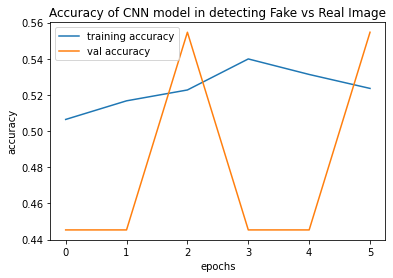

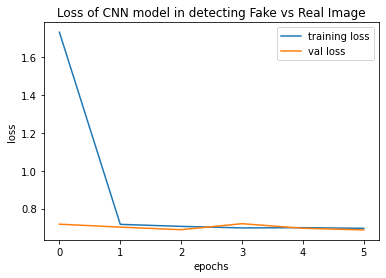

In [38]:
plt.figure(0)
plt.plot(lr_plot.history['accuracy'], label='training accuracy')
plt.plot(lr_plot.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy of CNN model in detecting Fake vs Real Image')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(lr_plot.history['loss'], label='training loss')
plt.plot(lr_plot.history['val_loss'], label='val loss')
plt.title('Loss of CNN model in detecting Fake vs Real Image')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [39]:
test_labels = pd.read_csv(project_path+'test.csv')

In [40]:
from tqdm import tqdm
import cv2
features = []
predictions = []

for f in tqdm(test_labels['file_id']): #f for image id, img for image class
  test_img = cv2.imread(project_path+'dataset/test/{}.jpg'.format(f),1) #0 for grayscale & 1 for rgb
  test_img_resize = cv2.resize(test_img, (img_size,img_size))

  img_array = tf.keras.preprocessing.image.img_to_array(test_img_resize)
  img_batch = img_array.reshape(1,img_size,img_size,channels) #Creating a batch of one-image
  img_preprocessed = preprocess_input(img_batch)
  predictions.append(np.round(model.predict(img_preprocessed,batch_size=1)))
  
  features.append(test_img_resize)

100%|██████████| 332/332 [00:19<00:00, 17.11it/s]


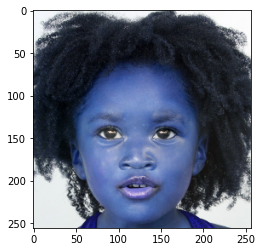

In [41]:
plt.imshow(features[0])

In [42]:
predictions=np.squeeze(predictions)#reducing the axis introduced earlier
#predictions[:10]
preds=pd.DataFrame(predictions)
filename = 'FakeVsRealImage.csv'
preds.to_csv(filename,index=True,index_label='file_id',header=['label'])
print('Saved file: ' + filename)

Saved file: FakeVsRealImage.csv
